# <h1><center>Brain Tumor Detection using CNN Model</center></h1>

# Data Preprocessing, Analysis, Splitting, Modelling and Evaluation

# 1. IMPORTING LIBRARIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Asadullah Irshad\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 2.0 DATA LOADING

In [2]:
# Check the folder inside the main path
os.listdir('../Downloads/Dataset/brain_tumor_dataset')

['no', 'yes']

# 3.0 DATA ANALYSIS

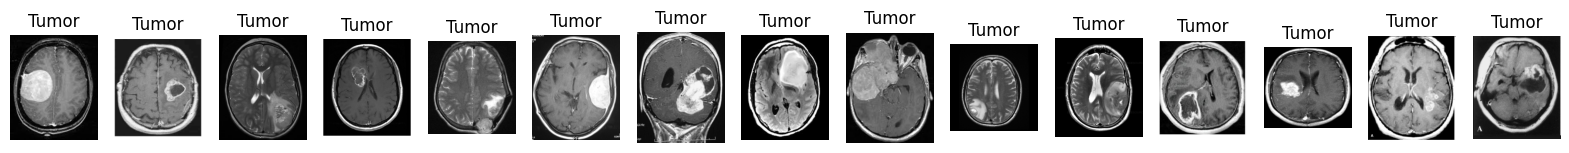

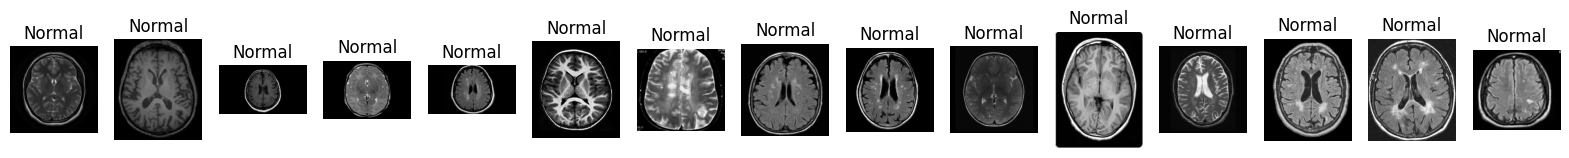

In [3]:
yes = '../Downloads/Dataset/brain_tumor_dataset/yes'
no =  '../Downloads/Dataset/brain_tumor_dataset/no'

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(yes , os.listdir(yes)[i])))
  plt.title('Tumor')
  plt.axis('off')
plt.show()

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(no , os.listdir(no)[i])))
  plt.title('Normal')
  plt.axis('off')
plt.show()

In [4]:
coronal = ('../Downloads/Dataset/brain_tumor_dataset/no/19 no.jpg')

# Check if the file exists before attempting to delete
if os.path.exists(coronal):
    # Delete the image file
    os.remove(coronal)
    print(f"The image {coronal} has been deleted.")
else:
    print(f"The image {coronal} does not exist.")

The image ../Downloads/Dataset/brain_tumor_dataset/no/19 no.jpg does not exist.


In [5]:
# Function to calculate the average size for a given folder
def average(folder_path):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Initialize variables to store total width and height
    total_width = 0
    total_height = 0
    num_images = 0

    # Loop through the files, load images, and calculate the total width and height
    for file in all_files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            width, height = img.size
            total_width += width
            total_height += height
            num_images += 1

    # Calculate the average size for the folder
    if num_images > 0:
        average_width = total_width / num_images
        average_height = total_height / num_images

        print(f"Average Width for {folder_path}: {round(average_width)}px x {round(average_height)}px")
    else:
        print(f"No images found with the specified extensions in {folder_path}.")


# Call the function for each folder
average(yes)
average(no)

Average Width for ../Downloads/Dataset/brain_tumor_dataset/yes: 361px x 414px
Average Width for ../Downloads/Dataset/brain_tumor_dataset/no: 345px x 344px


# 4.0 ATTRIBUTE SELECTION AND TRANSFORMATION

In [6]:
# Corrected full path to the dataset folder
df_path = '../Downloads/Dataset/brain_tumor_dataset'

# Load the dataset
dataframe = tf.keras.utils.image_dataset_from_directory(df_path, color_mode='grayscale')

Found 252 files belonging to 2 classes.


In [7]:
data_iterator = dataframe.as_numpy_iterator()

# Get one batch from the iterator
batch_data = data_iterator.next()

# Calculate the length of the batch
len(batch_data)

2

In [8]:
shape = batch_data[0].shape
print('Shape:', shape)

Shape: (32, 256, 256, 1)


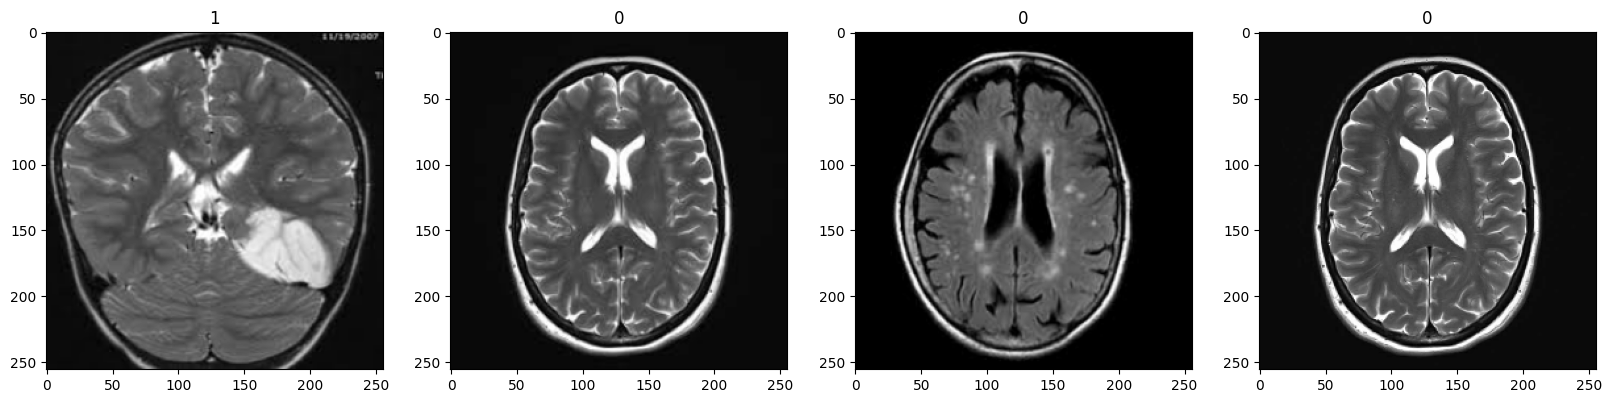

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch_data[0][:4]):
    ax[i].imshow(img.astype(int), cmap='gray')
    ax[i].title.set_text(batch_data[1][i])

# 5.0 DATA SCALING

In [10]:
data = dataframe.map(lambda x, y: (x / 255, y))

# 6.0 DATA SPLITTING

In [11]:
data_length = len(data)
data_length

8

In [12]:
train_size = int(data_length * 0.6)
val_size = int(data_length * 0.3)
test_size = int(data_length * 0.3)

print('Train Batch Size:', train_size)
print('Validation Batch Size:', val_size)
print('Test Batch Size:', test_size)

Train Batch Size: 4
Validation Batch Size: 2
Test Batch Size: 2


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:
train_batch = tf.data.experimental.cardinality(train).numpy()
val_batch = tf.data.experimental.cardinality(val).numpy()
test_batch = tf.data.experimental.cardinality(test).numpy()

print("Dataset Batch Information:")
print("-" * 30)
print("Train Dataset: Total Batches:", train_batch)
print("Validation Dataset: Total Batches:", val_batch)
print("Test Dataset: Total Batches:", test_batch)


Dataset Batch Information:
------------------------------
Train Dataset: Total Batches: 4
Validation Dataset: Total Batches: 2
Test Dataset: Total Batches: 2


# 7.0 CONVOLUTION MODEL

# 7.1 Early Stopping with 3-Convolution blocks

In [105]:
# Create a CNN model with 3 convolutional blocks
earlystopping_model = Sequential()

earlystopping_model.add(Conv2D(16, (5, 5), 3, activation='elu', padding='same', input_shape=(256, 256, 1)))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Conv2D(32, (5, 5), 3, activation='elu', padding='same'))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Conv2D(64, (5, 5), 3, activation='elu', padding='same'))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Flatten())
earlystopping_model.add(Dense(256, activation='elu'))
earlystopping_model.add(Dense(1, activation='sigmoid'))

In [106]:
# Compile the model
earlystopping_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
# Display model summary
earlystopping_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 86, 86, 16)        416       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 15, 15, 32)        12832     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 3, 3, 64)          51264     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 1, 1, 64)       

In [108]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7.1.1 Model Training Early Stopping

In [109]:
history = earlystopping_model.fit(
    train,
    epochs=40,
    validation_data=val,
    callbacks=[early_stopping]
)

Epoch 1/40
4/4 [==============================] - 2s 199ms/step - loss: 0.6736 - accuracy: 0.5078 - val_loss: 0.5814 - val_accuracy: 0.7031
Epoch 2/40
4/4 [==============================] - 1s 163ms/step - loss: 0.6199 - accuracy: 0.6328 - val_loss: 0.6062 - val_accuracy: 0.5938
Epoch 3/40
4/4 [==============================] - 1s 173ms/step - loss: 0.6142 - accuracy: 0.6094 - val_loss: 0.5559 - val_accuracy: 0.7188
Epoch 4/40
4/4 [==============================] - 1s 184ms/step - loss: 0.5717 - accuracy: 0.6875 - val_loss: 0.5695 - val_accuracy: 0.6875
Epoch 5/40
4/4 [==============================] - 1s 169ms/step - loss: 0.5565 - accuracy: 0.7734 - val_loss: 0.5435 - val_accuracy: 0.7656
Epoch 6/40
4/4 [==============================] - 1s 162ms/step - loss: 0.5514 - accuracy: 0.7656 - val_loss: 0.5494 - val_accuracy: 0.7188
Epoch 7/40
4/4 [==============================] - 1s 162ms/step - loss: 0.4761 - accuracy: 0.8125 - val_loss: 0.5157 - val_accuracy: 0.7344
Epoch 8/40
4/4 [====

# 7.1.2 Model Evaluation Early Stopping Model

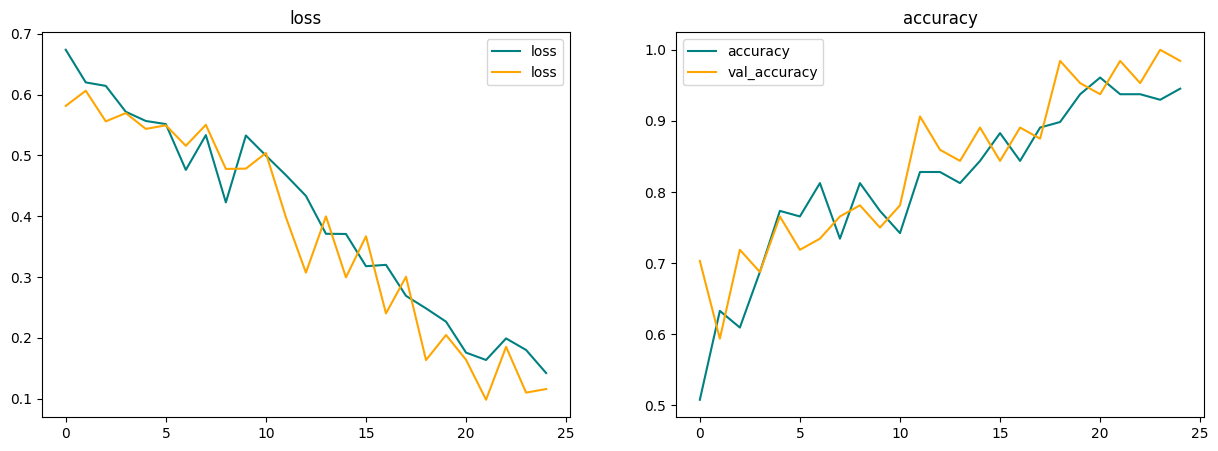

In [110]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [111]:
# Create metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Iterate through batches in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Make predictions using the model
    y_pred = earlystopping_model.predict(X)
    
    # Update metrics with true labels and predictions
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 63ms/step


In [112]:
# Print calculated precision, recall, and accuracy metrics
print(f'Precision : {precision.result()}')
print(f'Recall : {recall.result()}')
print(f'Accuracy : {accuracy.result()}')

Precision : 0.9189189076423645
Recall : 1.0
Accuracy : 0.949999988079071


In [113]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the train set
for batch in train.as_numpy_iterator():
    X, y = batch
    y_pred = earlystopping_model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the train set

print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 47ms/step
Precision (Train-Set) : 0.9624999761581421
Recall (Train-Set) : 0.9746835231781006
Accuracy (Train-Set) : 0.9609375


In [114]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the validation set
for batch in val.as_numpy_iterator():
    X, y = batch
    y_pred = earlystopping_model.predict(X)
    
    # Update metrics
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the validation set
print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 31ms/step
Precision (Validation-Set) : 0.9333333373069763
Recall (Validation-Set) : 0.9767441749572754
Accuracy (Validation-Set) : 0.9375


In [115]:
tp_count, fp_count, tn_count, fn_count = 0, 0, 0, 0

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = earlystopping_model.predict(X)

    # Round the probabilities to get binary predictions (0 or 1)
    y_pred_binary = np.round(y_pred).astype(int)

    # Calculate true positive, false positive, true negative, and false negative counts
    for true_label, pred_label in zip(y, y_pred_binary):
        if true_label == 1 and pred_label == 1:
            tp_count += 1
        elif true_label == 0 and pred_label == 1:
            fp_count += 1
        elif true_label == 1 and pred_label == 0:
            fn_count += 1
        elif true_label == 0 and pred_label == 0:
            tn_count += 1

# Print confusion matrix and performance metrics
print(f'Confusion Matrix:')
print(f'True Negatives: {tn_count}, False Positives: {fp_count}')
print(f'False Negatives: {fn_count}, True Positives: {tp_count}')

1/1 [==============================] - 0s 47ms/step
Confusion Matrix:
True Negatives: 23, False Positives: 2
False Negatives: 0, True Positives: 35


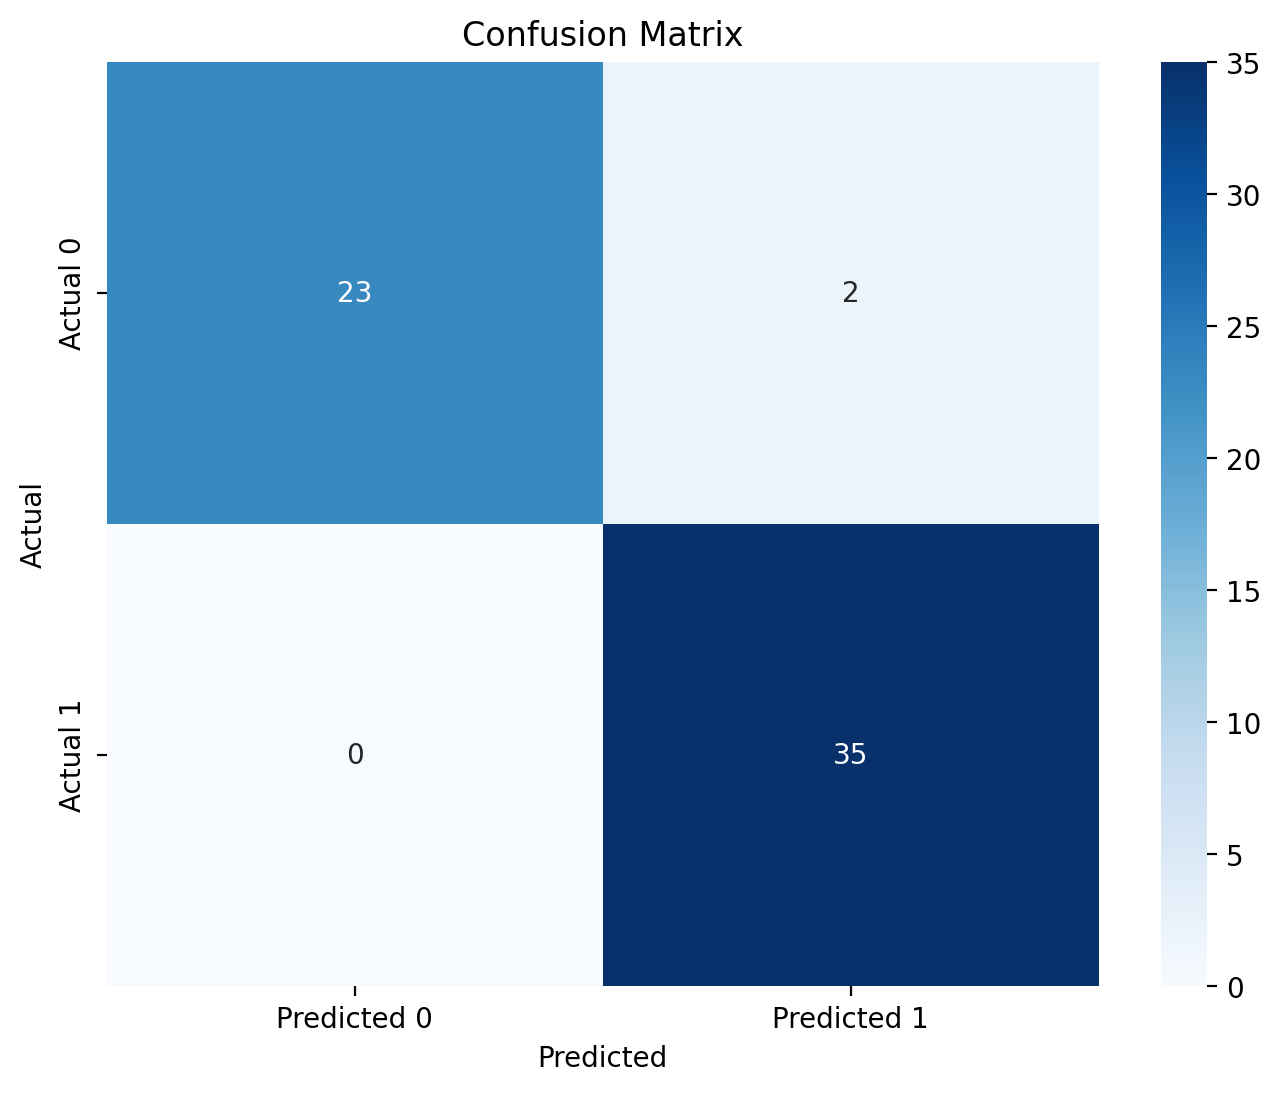

In [116]:
# Set up the figure
plt.figure(dpi=200, figsize=(8, 6))

# Create the confusion matrix
conf_matrix = [[tn_count, fp_count], [fn_count, tp_count]]

# Create a heatmap for the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

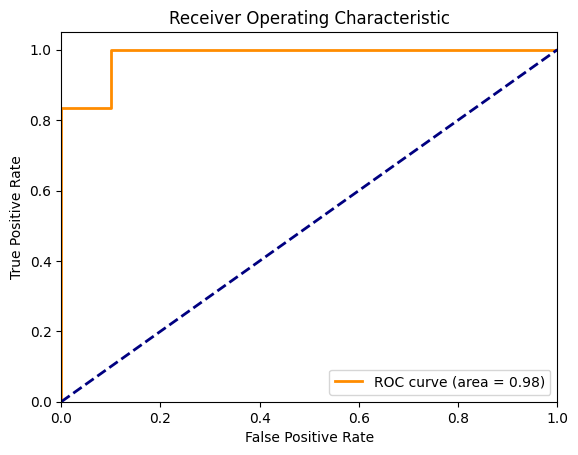

In [117]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 7.2 2-Convolutional Blocks

In [142]:
# Create a CNN model with 2 convolutional blocks
model_CB2 = Sequential()
model_CB2.add((Conv2D(16, (5, 5), 3, activation='elu', padding='same', input_shape=(256, 256, 1))))
model_CB2.add(MaxPooling2D())
model_CB2.add(Conv2D(8, (5, 5), 3, activation='elu', padding='same'))
model_CB2.add(MaxPooling2D())
model_CB2.add(Flatten())
model_CB2.add(Dense(256, activation='elu'))
model_CB2.add(Dense(1, activation='sigmoid'))

In [143]:
# Compile the model
model_CB2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [144]:
# Display model summary
model_CB2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 86, 86, 16)        416       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 15, 15, 8)         3208      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 392)               0         
                                                                 
 dense_50 (Dense)            (None, 256)             

# 7.2.1 Model Training Convolution Block 2

In [145]:
#Training the model with 40 epochs
history = model_CB2.fit(
    train,
    epochs=40,
    validation_data=val,
)

Epoch 1/40
4/4 [==============================] - 2s 206ms/step - loss: 0.6079 - accuracy: 0.6250 - val_loss: 0.6082 - val_accuracy: 0.6406
Epoch 2/40
4/4 [==============================] - 1s 178ms/step - loss: 0.5260 - accuracy: 0.7578 - val_loss: 0.5508 - val_accuracy: 0.7344
Epoch 3/40
4/4 [==============================] - 1s 193ms/step - loss: 0.5357 - accuracy: 0.7344 - val_loss: 0.4502 - val_accuracy: 0.7969
Epoch 4/40
4/4 [==============================] - 1s 198ms/step - loss: 0.4935 - accuracy: 0.7578 - val_loss: 0.4762 - val_accuracy: 0.7812
Epoch 5/40
4/4 [==============================] - 1s 174ms/step - loss: 0.4878 - accuracy: 0.7891 - val_loss: 0.4569 - val_accuracy: 0.8125
Epoch 6/40
4/4 [==============================] - 1s 183ms/step - loss: 0.4658 - accuracy: 0.7969 - val_loss: 0.3607 - val_accuracy: 0.8438
Epoch 7/40
4/4 [==============================] - 1s 167ms/step - loss: 0.4545 - accuracy: 0.8125 - val_loss: 0.4918 - val_accuracy: 0.7812
Epoch 8/40
4/4 [====

# 7.2.2 Model Evaluation Convolutional Block 2

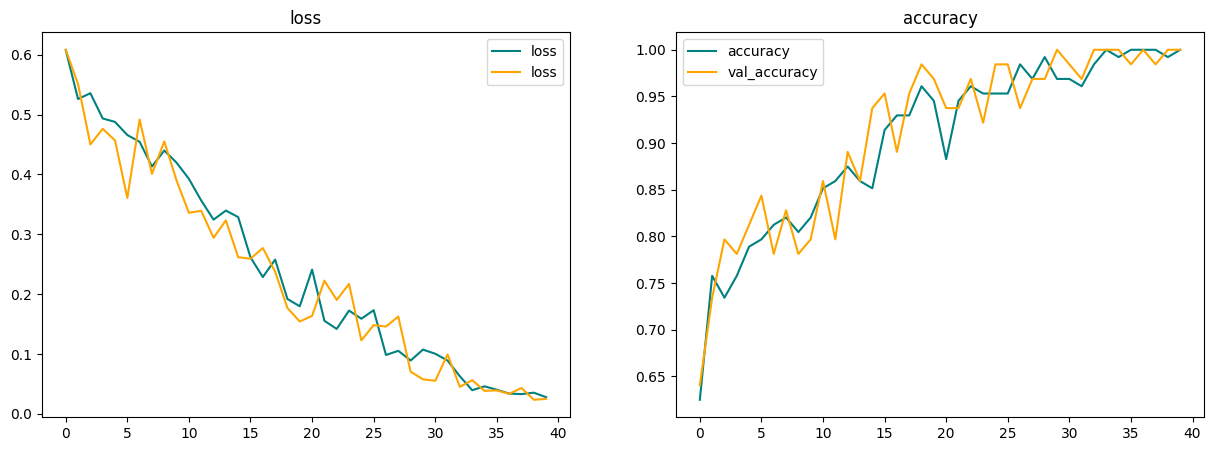

In [146]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [147]:
# Create metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Iterate through batches in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Make predictions using the model
    y_pred = model_CB2.predict(X)
    
    # Update metrics with true labels and predictions
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 78ms/step


In [148]:
# Print calculated precision, recall, and accuracy metrics
print(f'Precision : {precision.result()}')
print(f'Recall : {recall.result()}')
print(f'Accuracy : {accuracy.result()}')

Precision : 1.0
Recall : 1.0
Accuracy : 1.0


In [149]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the train set
for batch in train.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the train set
print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 47ms/step
Precision (Train-Set) : 1.0
Recall (Train-Set) : 1.0
Accuracy (Train-Set) : 1.0


In [150]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the validation set
for batch in val.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)
    
    # Update metrics
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the validation set
print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 62ms/step
Precision (Validation-Set) : 1.0
Recall (Validation-Set) : 1.0
Accuracy (Validation-Set) : 1.0


In [151]:
tp_count, fp_count, tn_count, fn_count = 0, 0, 0, 0

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)

    # Round the probabilities to get binary predictions (0 or 1)
    y_pred_binary = np.round(y_pred).astype(int)

    # Calculate true positive, false positive, true negative, and false negative counts
    for true_label, pred_label in zip(y, y_pred_binary):
        if true_label == 1 and pred_label == 1:
            tp_count += 1
        elif true_label == 0 and pred_label == 1:
            fp_count += 1
        elif true_label == 1 and pred_label == 0:
            fn_count += 1
        elif true_label == 0 and pred_label == 0:
            tn_count += 1

# Print confusion matrix and performance metrics
print(f'Confusion Matrix:')
print(f'True Negatives: {tn_count}, False Positives: {fp_count}')
print(f'False Negatives: {fn_count}, True Positives: {tp_count}')

1/1 [==============================] - 0s 47ms/step
Confusion Matrix:
True Negatives: 23, False Positives: 0
False Negatives: 0, True Positives: 37


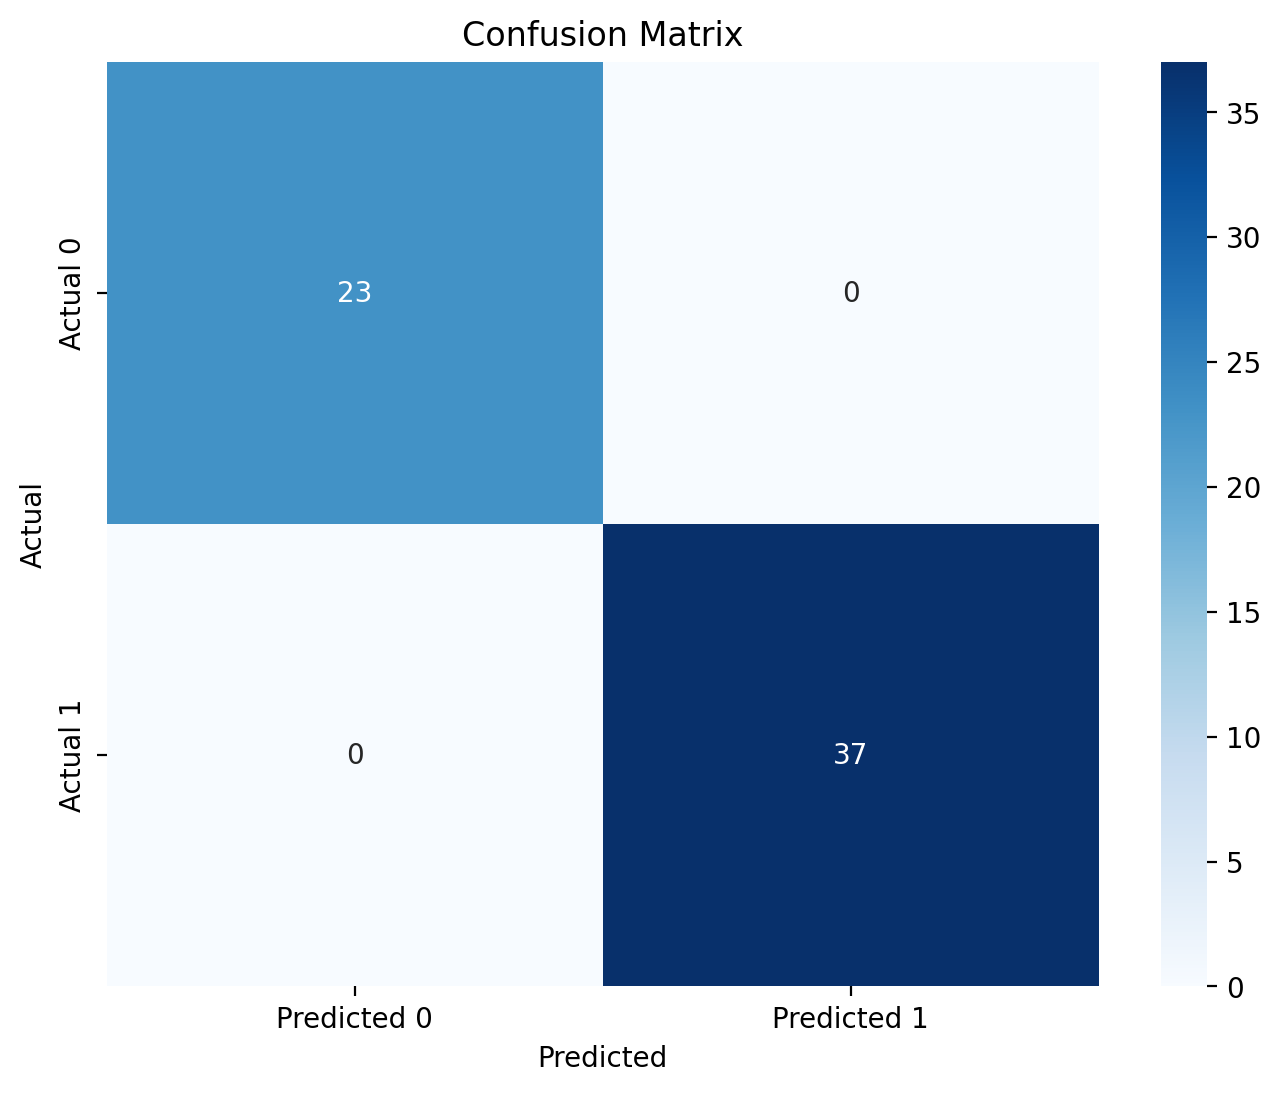

In [152]:
import seaborn as sns

# Set up the figure
plt.figure(dpi=200, figsize=(8, 6))

# Create the confusion matrix
conf_matrix = [[tn_count, fp_count], [fn_count, tp_count]]

# Create a heatmap for the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

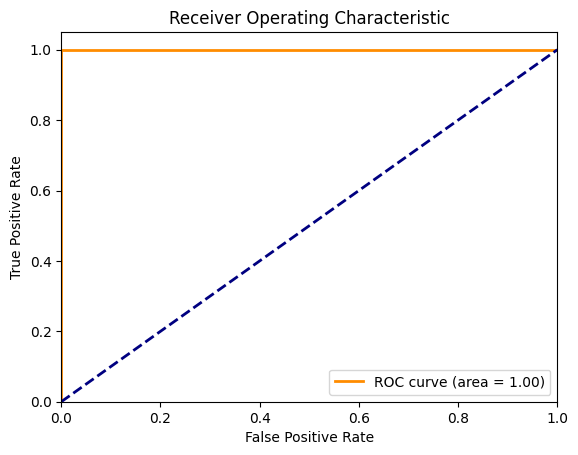

In [153]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# 7.3 Convolutional Block 3 with Data Augmentation

In [40]:
# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [41]:
# Create a CNN model with 3 convolutional blocks
earlystopping_model = Sequential()

earlystopping_model.add(Conv2D(16, (5, 5), 3, activation='elu', padding='same', input_shape=(256, 256, 1)))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Conv2D(32, (5, 5), 3, activation='elu', padding='same'))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Conv2D(64, (5, 5), 3, activation='elu', padding='same'))
earlystopping_model.add(MaxPooling2D())
earlystopping_model.add(Flatten())
earlystopping_model.add(Dense(256, activation='elu'))
earlystopping_model.add(Dense(1, activation='sigmoid'))

In [42]:
# Compile the model
earlystopping_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Display model summary
earlystopping_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 86, 86, 16)        416       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        12832     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)          51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 64)        

In [44]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7.3.1 Model Training CB3 with Data Augmentation

In [45]:
history = earlystopping_model.fit(
    train,
    epochs=40,
    validation_data=val,
    callbacks=[early_stopping]
)

Epoch 1/40
4/4 [==============================] - 2s 214ms/step - loss: 0.6848 - accuracy: 0.5391 - val_loss: 0.6684 - val_accuracy: 0.5156
Epoch 2/40
4/4 [==============================] - 1s 136ms/step - loss: 0.6070 - accuracy: 0.6406 - val_loss: 0.5453 - val_accuracy: 0.7188
Epoch 3/40
4/4 [==============================] - 1s 150ms/step - loss: 0.6049 - accuracy: 0.6641 - val_loss: 0.5392 - val_accuracy: 0.7812
Epoch 4/40
4/4 [==============================] - 1s 152ms/step - loss: 0.5687 - accuracy: 0.7266 - val_loss: 0.5349 - val_accuracy: 0.7656
Epoch 5/40
4/4 [==============================] - 1s 152ms/step - loss: 0.5412 - accuracy: 0.7812 - val_loss: 0.4629 - val_accuracy: 0.7969
Epoch 6/40
4/4 [==============================] - 1s 131ms/step - loss: 0.4980 - accuracy: 0.7656 - val_loss: 0.5082 - val_accuracy: 0.7969
Epoch 7/40
4/4 [==============================] - 1s 152ms/step - loss: 0.4930 - accuracy: 0.7812 - val_loss: 0.4827 - val_accuracy: 0.7969
Epoch 8/40
4/4 [====

# 7.3.2 Model Evaluation CB3 with Data Augmentation

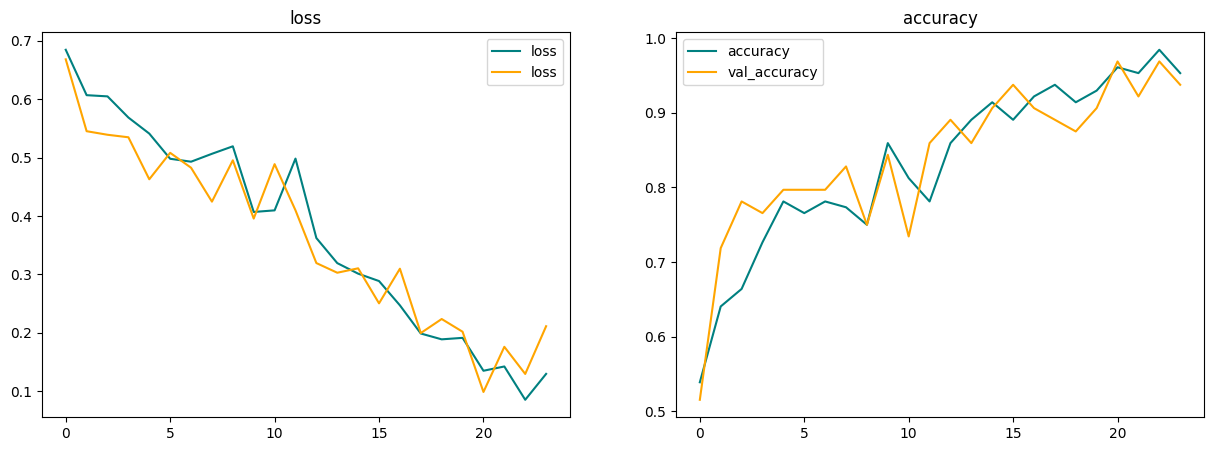

In [46]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [47]:
# Create metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Iterate through batches in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Make predictions using the model
    y_pred = earlystopping_model.predict(X)
    
    # Update metrics with true labels and predictions
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 79ms/step


In [48]:
# Print calculated precision, recall, and accuracy metrics
print(f'Precision : {precision.result()}')
print(f'Recall : {recall.result()}')
print(f'Accuracy : {accuracy.result()}')

Precision : 0.9696969985961914
Recall : 0.9142857193946838
Accuracy : 0.9333333373069763


In [49]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the train set
for batch in train.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the train set
print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 47ms/step
Precision (Train-Set) : 0.9666666388511658
Recall (Train-Set) : 1.0
Accuracy (Train-Set) : 0.9765625


In [50]:
# Initialize metric objects
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Calculate metrics for the validation set
for batch in val.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)
    
    # Update metrics
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

# Print calculated metrics for the validation set
print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 31ms/step
Precision (Validation-Set) : 0.9523809552192688
Recall (Validation-Set) : 1.0
Accuracy (Validation-Set) : 0.96875


In [51]:
tp_count, fp_count, tn_count, fn_count = 0, 0, 0, 0

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model_CB2.predict(X)

    # Round the probabilities to get binary predictions (0 or 1)
    y_pred_binary = np.round(y_pred).astype(int)

    # Calculate true positive, false positive, true negative, and false negative counts
    for true_label, pred_label in zip(y, y_pred_binary):
        if true_label == 1 and pred_label == 1:
            tp_count += 1
        elif true_label == 0 and pred_label == 1:
            fp_count += 1
        elif true_label == 1 and pred_label == 0:
            fn_count += 1
        elif true_label == 0 and pred_label == 0:
            tn_count += 1

# Print confusion matrix and performance metrics
print(f'Confusion Matrix:')
print(f'True Negatives: {tn_count}, False Positives: {fp_count}')
print(f'False Negatives: {fn_count}, True Positives: {tp_count}')

1/1 [==============================] - 0s 32ms/step
Confusion Matrix:
True Negatives: 24, False Positives: 0
False Negatives: 0, True Positives: 36


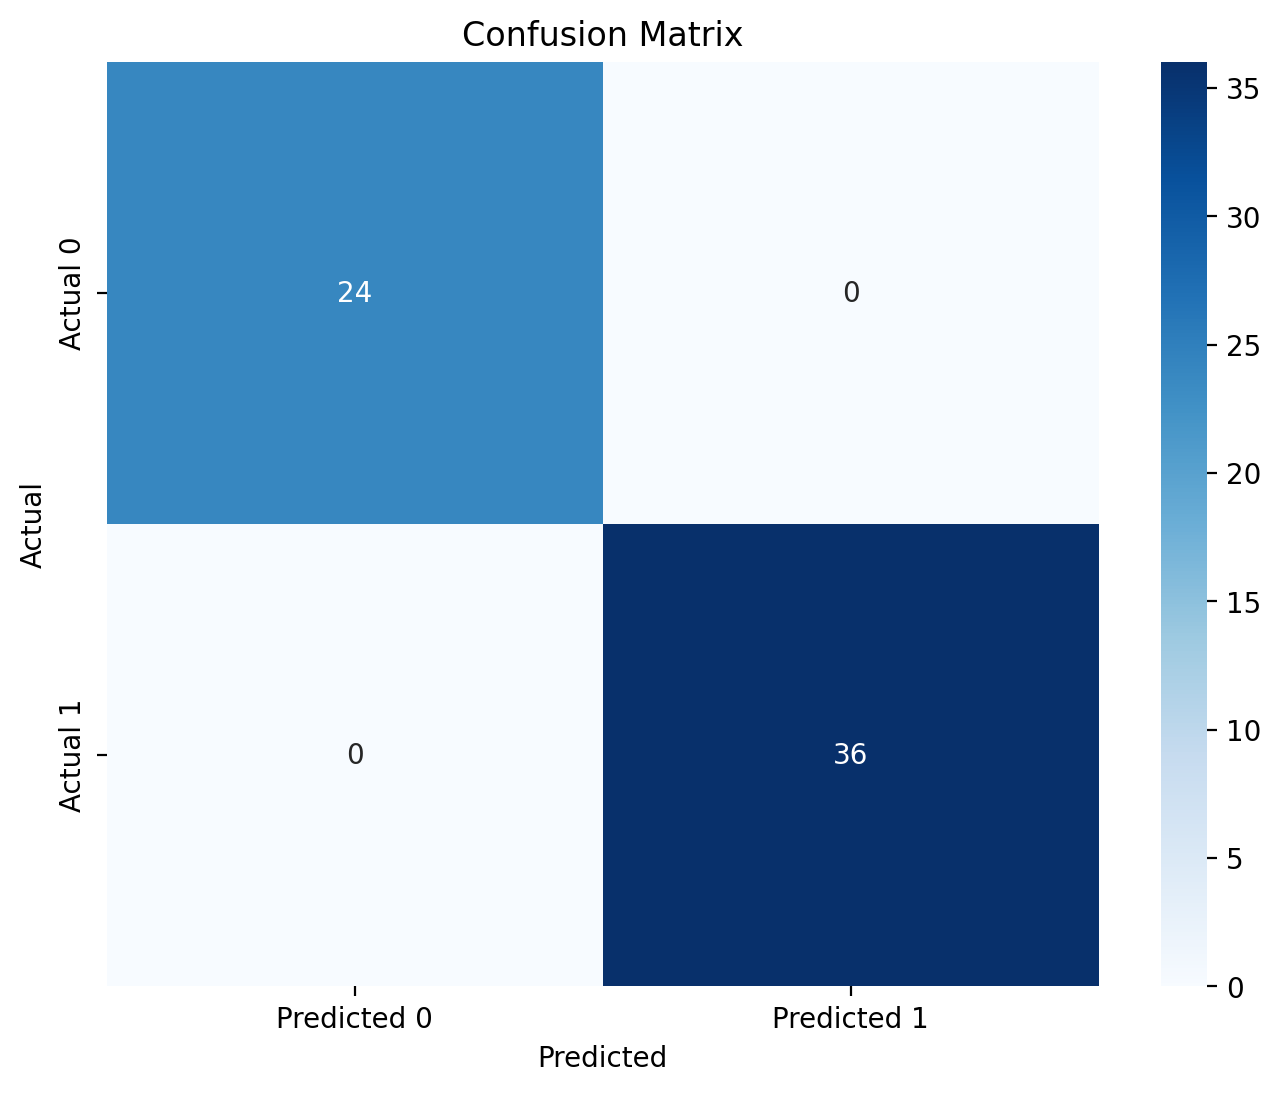

In [52]:
import seaborn as sns

# Set up the figure
plt.figure(dpi=200, figsize=(8, 6))

# Create the confusion matrix
conf_matrix = [[tn_count, fp_count], [fn_count, tp_count]]

# Create a heatmap for the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

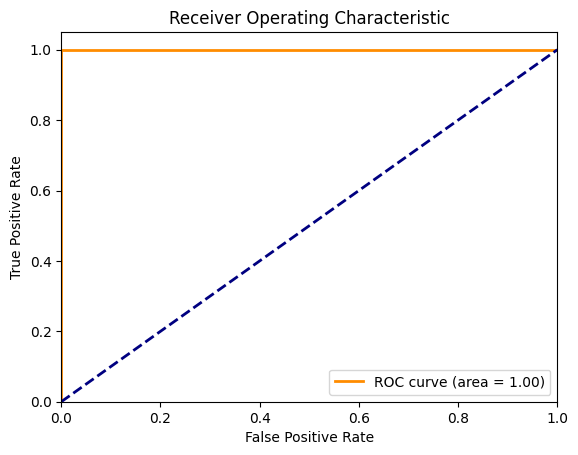

In [53]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

We can see that there is no noticeable gap in those scores, which means the model is actually considered a good-fit. However, we can still improve the performance

# 8.0 VGG MODEL

In [2]:
train_data_dir = '../Downloads/Dataset/brain_tumor_dataset'

datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # using 20% of the data for validation
)

batch_size = 32

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # set as training data
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # set as validation data
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [3]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

In [4]:
# FC layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [5]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                   

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 8.1 Model Training VGG

In [7]:
# Train Model

history = model.fit(
    train_generator,
    epochs=40,
    steps_per_epoch=len(train_generator),
    validation_data=train_generator,
    validation_steps=len(train_generator),
    verbose=1
)


Epoch 1/40
7/7 [==============================] - 56s 8s/step - loss: 1.2568 - accuracy: 0.4877 - val_loss: 0.6800 - val_accuracy: 0.6108
Epoch 2/40
7/7 [==============================] - 56s 8s/step - loss: 0.6524 - accuracy: 0.6108 - val_loss: 0.6181 - val_accuracy: 0.6108
Epoch 3/40
7/7 [==============================] - 55s 8s/step - loss: 0.7148 - accuracy: 0.6108 - val_loss: 0.6912 - val_accuracy: 0.6108
Epoch 4/40
7/7 [==============================] - 56s 8s/step - loss: 0.6840 - accuracy: 0.6108 - val_loss: 0.6766 - val_accuracy: 0.6108
Epoch 5/40
7/7 [==============================] - 55s 8s/step - loss: 0.6704 - accuracy: 0.6108 - val_loss: 0.6691 - val_accuracy: 0.6108
Epoch 6/40
7/7 [==============================] - 55s 8s/step - loss: 0.6636 - accuracy: 0.6108 - val_loss: 0.6691 - val_accuracy: 0.6108
Epoch 7/40
7/7 [==============================] - 55s 8s/step - loss: 0.6703 - accuracy: 0.6108 - val_loss: 0.6679 - val_accuracy: 0.6108
Epoch 8/40
7/7 [==================

# 8.1.1 Model Evaluation VGG

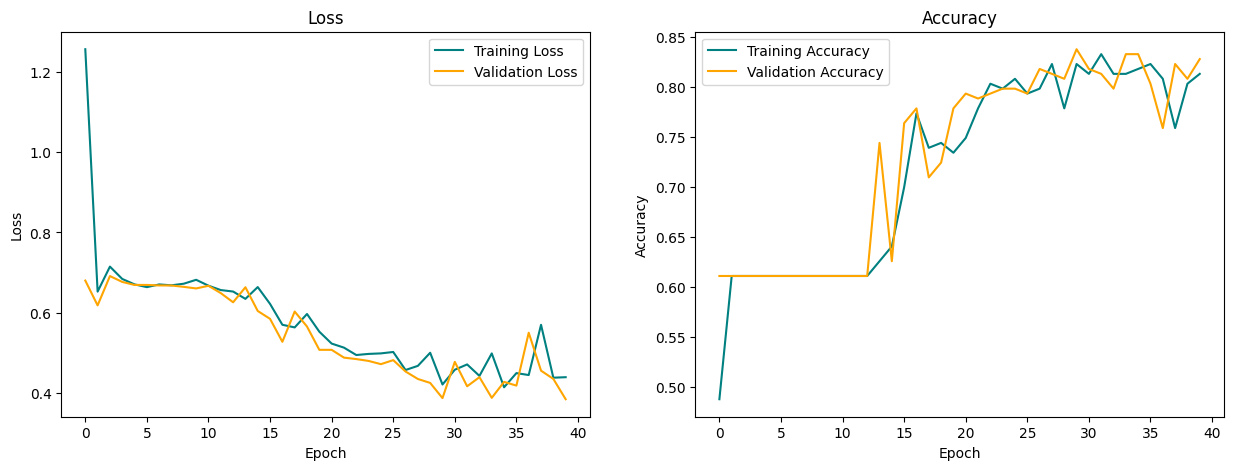

In [8]:
fig = plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='teal', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


2/2 [==============================] - 3s 1s/step


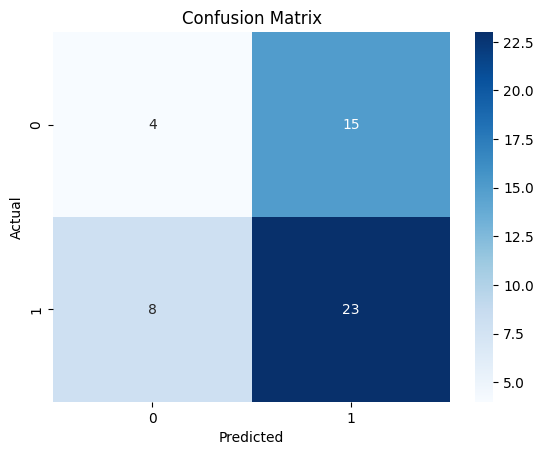

In [9]:
# Generate predictions
validation_steps = len(validation_generator)
predictions = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred = np.round(predictions)
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# Classification Report
print(classification_report(y_true[:len(y_pred)], y_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.33      0.21      0.26        19
         Yes       0.61      0.74      0.67        31

    accuracy                           0.54        50
   macro avg       0.47      0.48      0.46        50
weighted avg       0.50      0.54      0.51        50



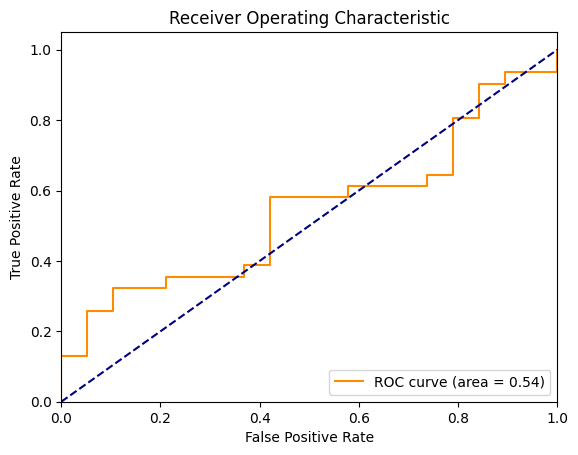

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true[:len(y_pred)], predictions)
roc_auc = roc_auc_score(y_true[:len(y_pred)], predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
